# TICA indicator basis, feature 1 reduced (518 dim->10 TICA coords->200 clusters)

In [1]:
import numpy as np
import extq
import matplotlib.pyplot as plt
from matplotlib import ticker
import pyemma
import glob
import sys
import importlib
import gc
import sklearn
from sklearn import metrics
import ivac
import seaborn as sns

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import kde

In [3]:
plt.style.use("seaborn-ticks")
sns.set_palette("colorblind")

# Load indicator basis/trajectories 

In [4]:
data_trajs = np.load("../../data/raw_feat/feat1_ivac_ind200.npy")

In [6]:
data_trajs.shape

(1, 6580000)

In [7]:
data_arr = data_trajs.squeeze()

In [8]:
data_arr.shape

(6580000,)

# Load IVAC data (100 indicators on salt bridge distances)

In [9]:
livac_trajs = np.load("../../data/sb_ind100_TICA/livac_trajs.npy", allow_pickle=True)
livac_arr = np.concatenate(livac_trajs)
models_km100 = np.load("../../data/sb_ind100_TICA/models.npy", allow_pickle=True)

In [10]:
# split data into trajectories
traj_lens = [len(traj) for traj in livac_trajs]
traj_inds = []
subtot = 0
for length in traj_lens[:-1]:
    subtot += length
    traj_inds.append(subtot)
data_trajs = np.split(data_arr, traj_inds)

# Load CVs 

In [6]:
with np.load("../../data/raw_feat/cv_dist_spin.npz", allow_pickle=True) as f:
    cv_arr = f["arr_0"]

In [13]:
cv_trajs = np.split(cv_arr, traj_inds)
print(len(cv_trajs))
print(cv_arr.shape)

1295
(6580000, 2)


In [14]:
with np.load("../../data/raw_feat/ri126_dist.npz", allow_pickle=True) as f:
    ri_trajs = f["arr_0"]
ri_arr = np.concatenate(ri_trajs)
ri_arr.shape

(6580000, 5)

In [15]:
with np.load("../../data/raw_feat/feat2_raw.npz", allow_pickle=True) as f:
    sb_trajs = f["arr_0"]

In [16]:
print(len(sb_trajs))
print(sb_trajs[0].shape)

1295
(3000, 60)


In [17]:
sb_arr = np.concatenate(sb_trajs)
print(sb_arr.shape)

(6580000, 60)


In [18]:
# useful salt bridges
# R223-D129, R226-D129, R229-D129, R226-D186, R229-D186, R232-D186
sb_ids = [36, 42, 48, 46, 52, 58]

In [19]:
cv_arr = np.hstack((cv_arr, sb_arr[:, sb_ids], ri_arr, livac_arr))

In [20]:
cv_arr.shape

(6580000, 18)

In [21]:
cv_trajs = np.split(cv_arr, traj_inds)

In [22]:
names = [
    "Distance / $\AA$",
    "Rotation / $^\circ$",
    "R1-D129",
    "R2-D129",
    "R3-D129",
    "R2-D186",
    "R3-D186",
    "R4-D186",
    "R0-I126",
    "R1-I126",
    "R2-I126",
    "R3-I126",
    "R4-I126",
    "iTIC0",
    "iTIC1",
    "iTIC2",
    "iTIC3",
    "iTIC4",
]

# Refined states 

In [23]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
tic1 = livac_arr[:, 1]
sb = cv_arr[:, 2]  # R1-D129

# ellipse centered at (-8.919, -109.9) with radii 0.632 and 9.8 (1 sigma in each direction) for down- state
# take points where TIC 1 > 1.29 and R1-D129 distance > 0.8 nm
dist_ax_down = (dist + 8.919) / 0.632
rot_ax_down = (rot + 109.9) / 9.8
downmin_ids = (
    ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (tic1 > 1.29) & (sb > 0.8)
).nonzero()[0]

# ellipse centered at (4.535, 43.7) with radii 0.632 and 2.9 for up+ state
# take points where TIC 1 < -1.25
dist_ax_upp = (dist - 4.535) / 0.632
rot_ax_upp = (rot - 43.7) / 4.0
upplus_ids = (((dist_ax_upp ** 2 + rot_ax_upp ** 2) < 1) & (tic1 < -1.25)).nonzero()[0]

In [26]:
mask = np.ones(len(cv_arr), dtype=bool)
mask[downmin_ids] = False
mask[upplus_ids] = False

# len(**_ids) is number of points in each state
downmin = data_arr[downmin_ids]
upplus = data_arr[upplus_ids]
other = data_arr[mask]

# split CV data
downmin_cvs = cv_arr[downmin_ids]
upplus_cvs = cv_arr[upplus_ids]
other_cvs = cv_arr[mask]

In [27]:
assert (len(downmin) + len(upplus) + len(other)) == len(cv_arr)
print(f"Number of down- structures:  {len(downmin)}")
print(f"Number of up+ structures:   {len(upplus)}")
print(f"Number of other structures: {len(other)}")

Number of down- structures:  727
Number of up+ structures:   52683
Number of other structures: 6526590


# Basis 

In [58]:
guess_downmin = np.zeros_like(data_arr)
guess_downmin[downmin_ids] = 1
guessD = np.split(guess_downmin, traj_inds)
guess_upp = np.zeros_like(data_arr)
guess_upp[upplus_ids] = 1
guessU = np.split(guess_upp, traj_inds)

In [59]:
guess_downmin.shape

(6580000,)

In [35]:
# indicator basis
basisF_arr = np.zeros((len(cv_arr), 200))
for i in range(200):
    basisF_arr[data_arr == i, i] = 1

# enforce boundary conditions
basisF_arr[downmin_ids] = 0
basisF_arr[upplus_ids] = 0

In [37]:
assert basisF_arr[downmin_ids].all() == 0
assert basisF_arr[upplus_ids].all() == 0

In [38]:
# remove bases which are completely 0 (i.e. entirely contained in A U B)
nonzero = np.where(np.sum(basisF_arr, axis=0) > 0)[0]

basisF_arr = basisF_arr[:, nonzero]

In [39]:
basisF_arr.shape

(6580000, 200)

In [40]:
basisF = np.split(basisF_arr, traj_inds)

# Committor calculations 

In [5]:
# unit is 0.1 ps, up to 100 ns
lags = [1, 2, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000, 2000]

## Load weights 

In [32]:
weights = np.load("../../data/coms_feat1_ind200.npy", allow_pickle=True)

In [33]:
print(len(weights), len(weights[0]), len(weights[0][0]))

15 1295 3000


## all committors 

In [60]:
in_domain = np.split(mask, traj_inds)
q_downup, qb_downup, q_updown, qb_updown = [], [], [], []
for (lag, com) in zip(lags, weights):
    print(f"Calculating committors for lag {lag}")
    q_downup.append(extq.dga.forward_committor(basisF, com, in_domain, guessU, lag))
    qb_downup.append(extq.dga.backward_committor(basisF, com, in_domain, guessD, lag))
    q_updown.append(extq.dga.forward_committor(basisF, com, in_domain, guessD, lag))
    qb_updown.append(extq.dga.backward_committor(basisF, com, in_domain, guessU, lag))

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5
Calculating committors for lag 10
Calculating committors for lag 20
Calculating committors for lag 30
Calculating committors for lag 40
Calculating committors for lag 50
Calculating committors for lag 100
Calculating committors for lag 200
Calculating committors for lag 300
Calculating committors for lag 400
Calculating committors for lag 500
Calculating committors for lag 1000
Calculating committors for lag 2000


In [61]:
np.save("../../data/feat1_ind200_dduu/q_du_feat1.npy", q_downup)
np.save("../../data/feat1_ind200_dduu/qb_du_feat1.npy", qb_downup)
np.save("../../data/feat1_ind200_dduu/q_ud_feat1.npy", q_updown)
np.save("../../data/feat1_ind200_dduu/qb_ud_feat1.npy", qb_updown)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [4]:
q_downup = np.load("../../data/feat1_ind200_dduu/q_du_feat1.npy", allow_pickle=True)
qb_downup = np.load("../../data/feat1_ind200_dduu/qb_du_feat1.npy", allow_pickle=True)
q_updown = np.load("../../data/feat1_ind200_dduu/q_ud_feat1.npy", allow_pickle=True)
qb_updown = np.load("../../data/feat1_ind200_dduu/qb_ud_feat1.npy", allow_pickle=True)

## Activation (down to up) committor 

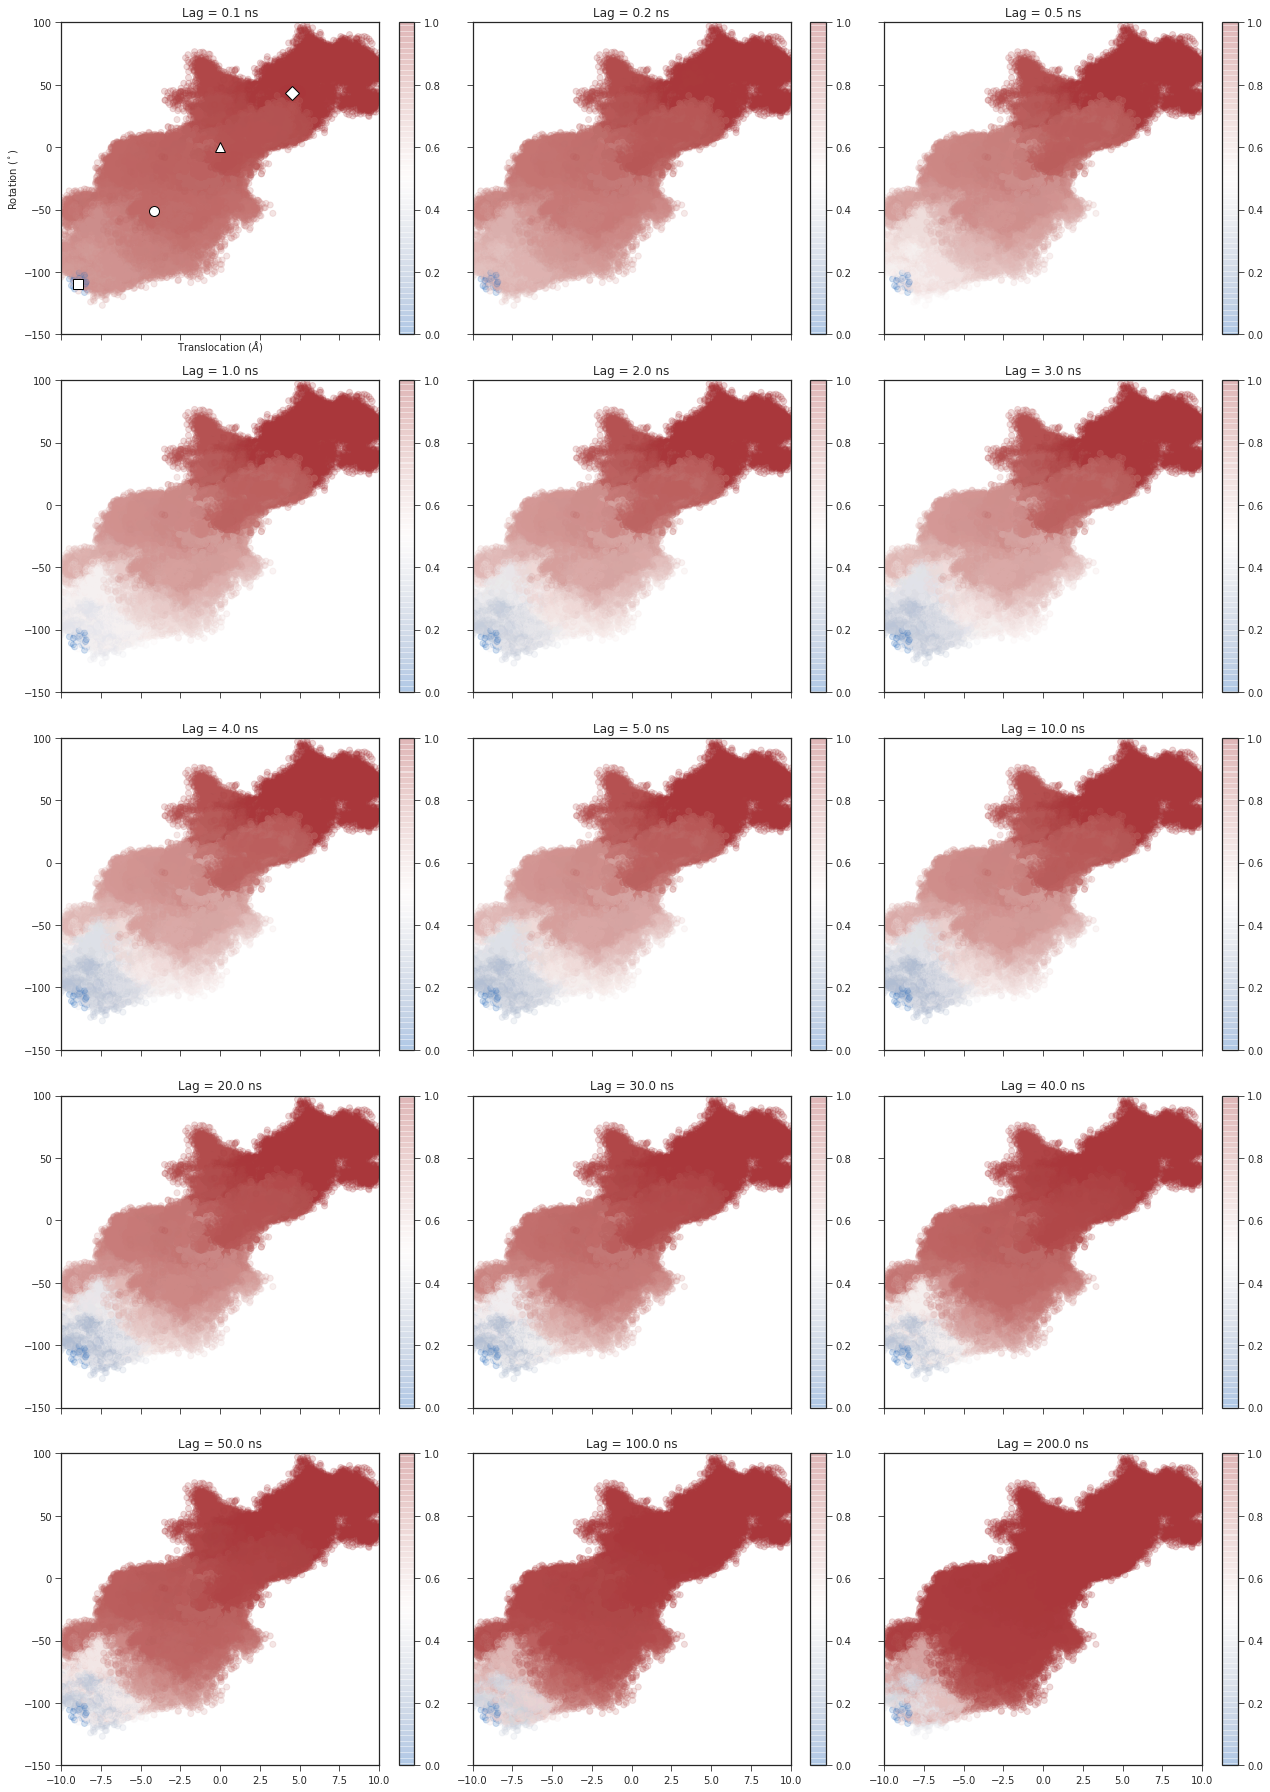

In [68]:
f, axs = plt.subplots(5, 3, figsize=(18, 25), sharex=True, sharey=True)
for lag, q, ax in zip(lags, q_downup, axs.flatten()):
    q_arr = np.concatenate(q)
    h = ax.scatter(
        cv_arr[::10, 0], cv_arr[::10, 1], c=q_arr[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set_title(f"Lag = {lag * 0.1} ns")
util.format_cvs(axs[0][0])

f.tight_layout()
plt.savefig("../../fig/committors/qf_ind200_activation_alllags_ds", dpi=400)

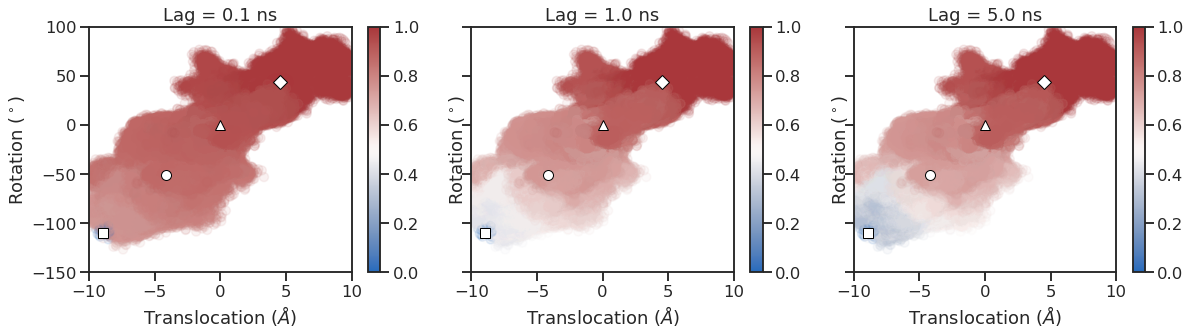

In [8]:
sns.set_context("talk")
f, axs = plt.subplots(1, 3, figsize=(17, 5), sharex=True, sharey=True)
# compare 0.1, 1.0, and 5.0 ns lags
lag_inds = (0, 3, 7)
for lag, q, ax in zip(
    [lags[i] for i in lag_inds], [q_downup[i] for i in lag_inds], axs.flatten()
):
    q_arr = np.concatenate(q)
    h = ax.scatter(
        cv_arr[::10, 0], cv_arr[::10, 1], c=q_arr[::10], cmap="vlag", alpha=0.1
    )
    cbar = plt.colorbar(h, ax=ax)
    cbar.solids.set(alpha=1)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    util.format_cvs(ax)
f.tight_layout()
plt.savefig("../../fig/talks/qf_feat1ind200_activation_3lags_ds", dpi=300)

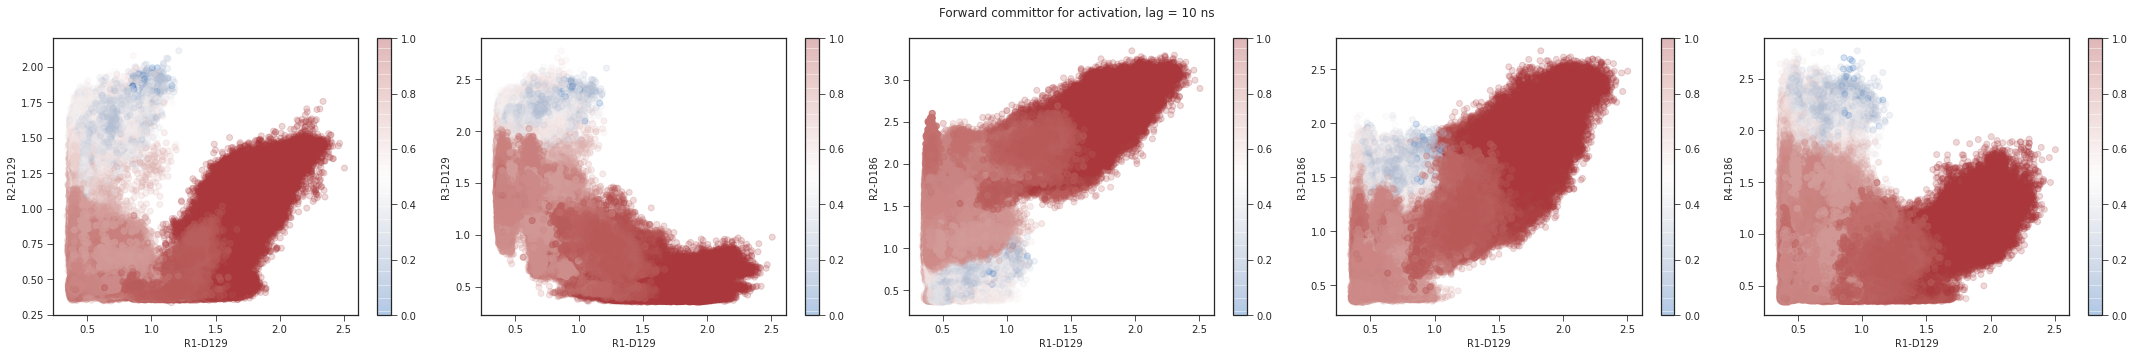

In [72]:
f, axs = plt.subplots(1, 5, figsize=(30, 5), sharex=True)
q = np.concatenate(q_downup[8])
for i, ax in enumerate(axs):
    h = ax.scatter(
        cv_arr[::10, 2], cv_arr[::10, i + 3], c=q[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set(xlabel=names[2], ylabel=names[i + 3])
f.suptitle("Forward committor for activation, lag = 10 ns")
f.tight_layout()
plt.savefig("../../fig/committors/qf_ind200_activation_lag100_sb_r1-all")

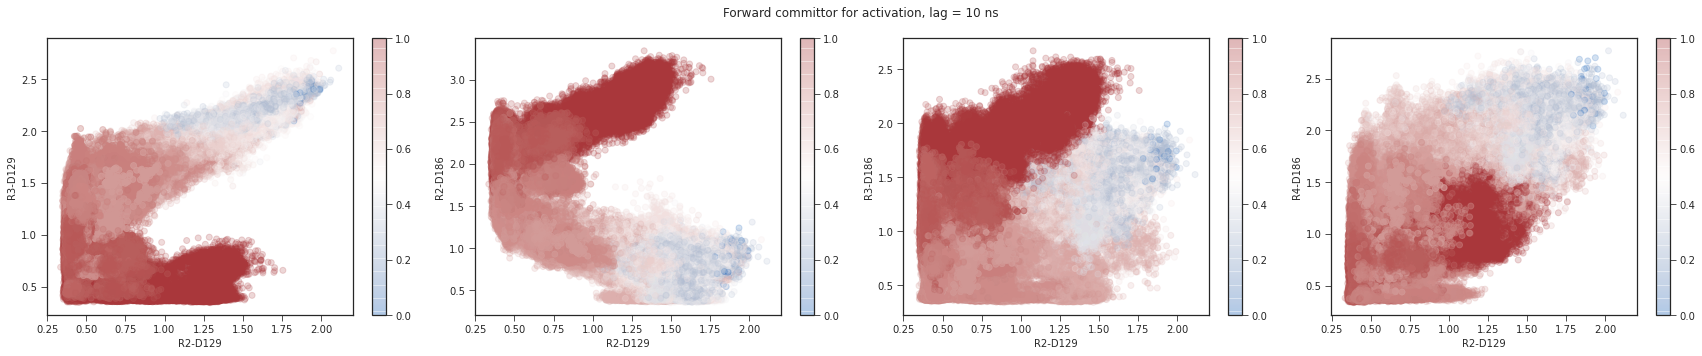

In [73]:
f, axs = plt.subplots(1, 4, figsize=(24, 5), sharex=True)
q = np.concatenate(q_downup[8])
for i, ax in enumerate(axs):
    h = ax.scatter(
        cv_arr[::10, 3], cv_arr[::10, i + 4], c=q[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set(xlabel=names[3], ylabel=names[i + 4])
f.suptitle("Forward committor for activation, lag = 10 ns")
f.tight_layout()
plt.savefig("../../fig/committors/qf_ind200_activation_lag100_sb_r2-all")

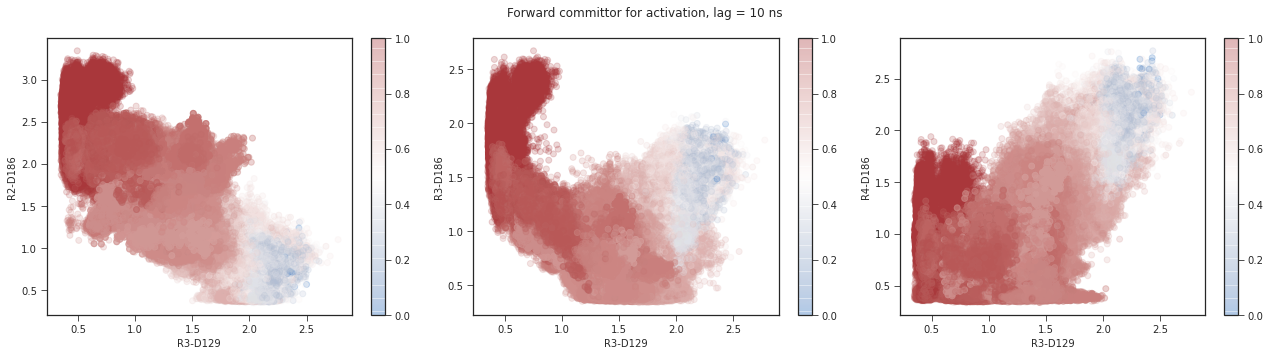

In [74]:
f, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
q = np.concatenate(q_downup[8])
for i, ax in enumerate(axs):
    h = ax.scatter(
        cv_arr[::10, 4], cv_arr[::10, i + 5], c=q[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set(xlabel=names[4], ylabel=names[i + 5])
f.suptitle("Forward committor for activation, lag = 10 ns")
f.tight_layout()
plt.savefig("../../fig/committors/qf_ind200_activation_lag100_sb_r3-all")

In [67]:
gc.collect()

18501

In [76]:
from itertools import combinations

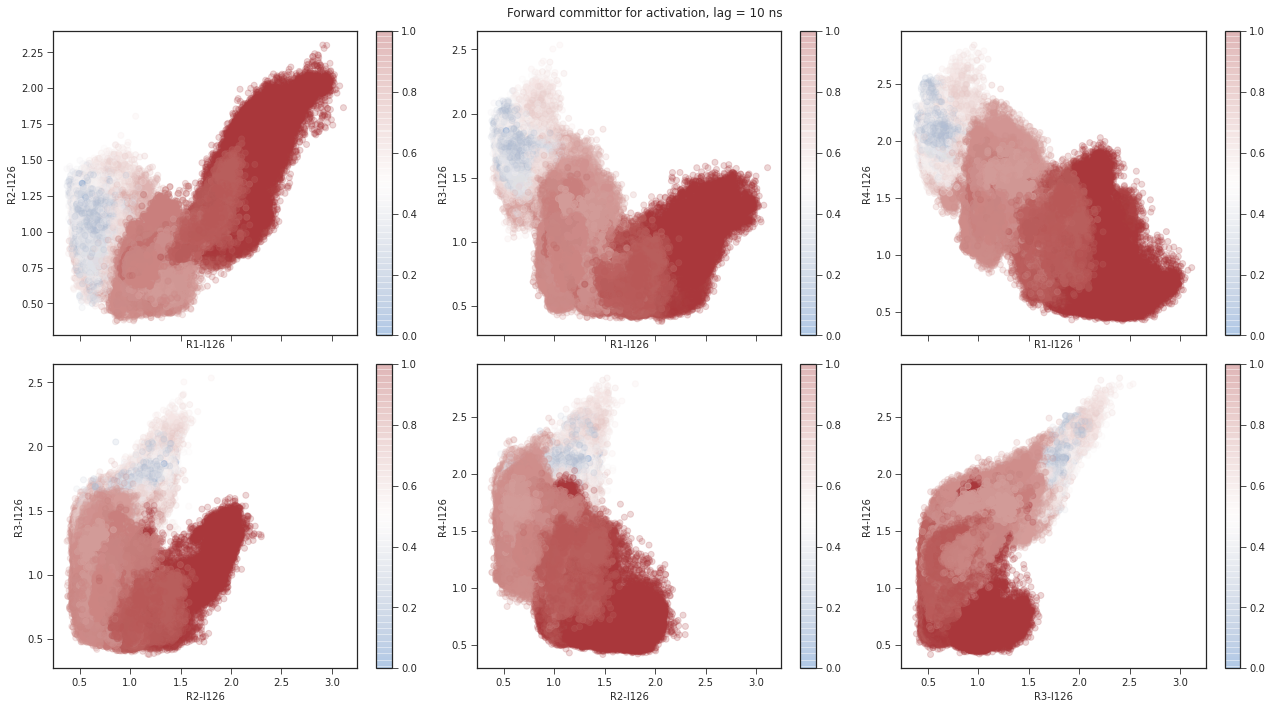

In [77]:
f, axs = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
q = np.concatenate(q_downup[8])
# plot against R(1-3)-I126 distances
for (i, j), ax in zip(combinations(range(9, 13), 2), axs.flatten()):
    h = ax.scatter(cv_arr[::10, i], cv_arr[::10, j], c=q[::10], cmap="vlag", alpha=0.2)
    plt.colorbar(h, ax=ax)
    ax.set(xlabel=names[i], ylabel=names[j])
f.suptitle("Forward committor for activation, lag = 10 ns")
f.tight_layout()
plt.savefig("../../fig/committors/qf_ind200_activation_lag100_ri126_all", dpi=400)

### backwards committor

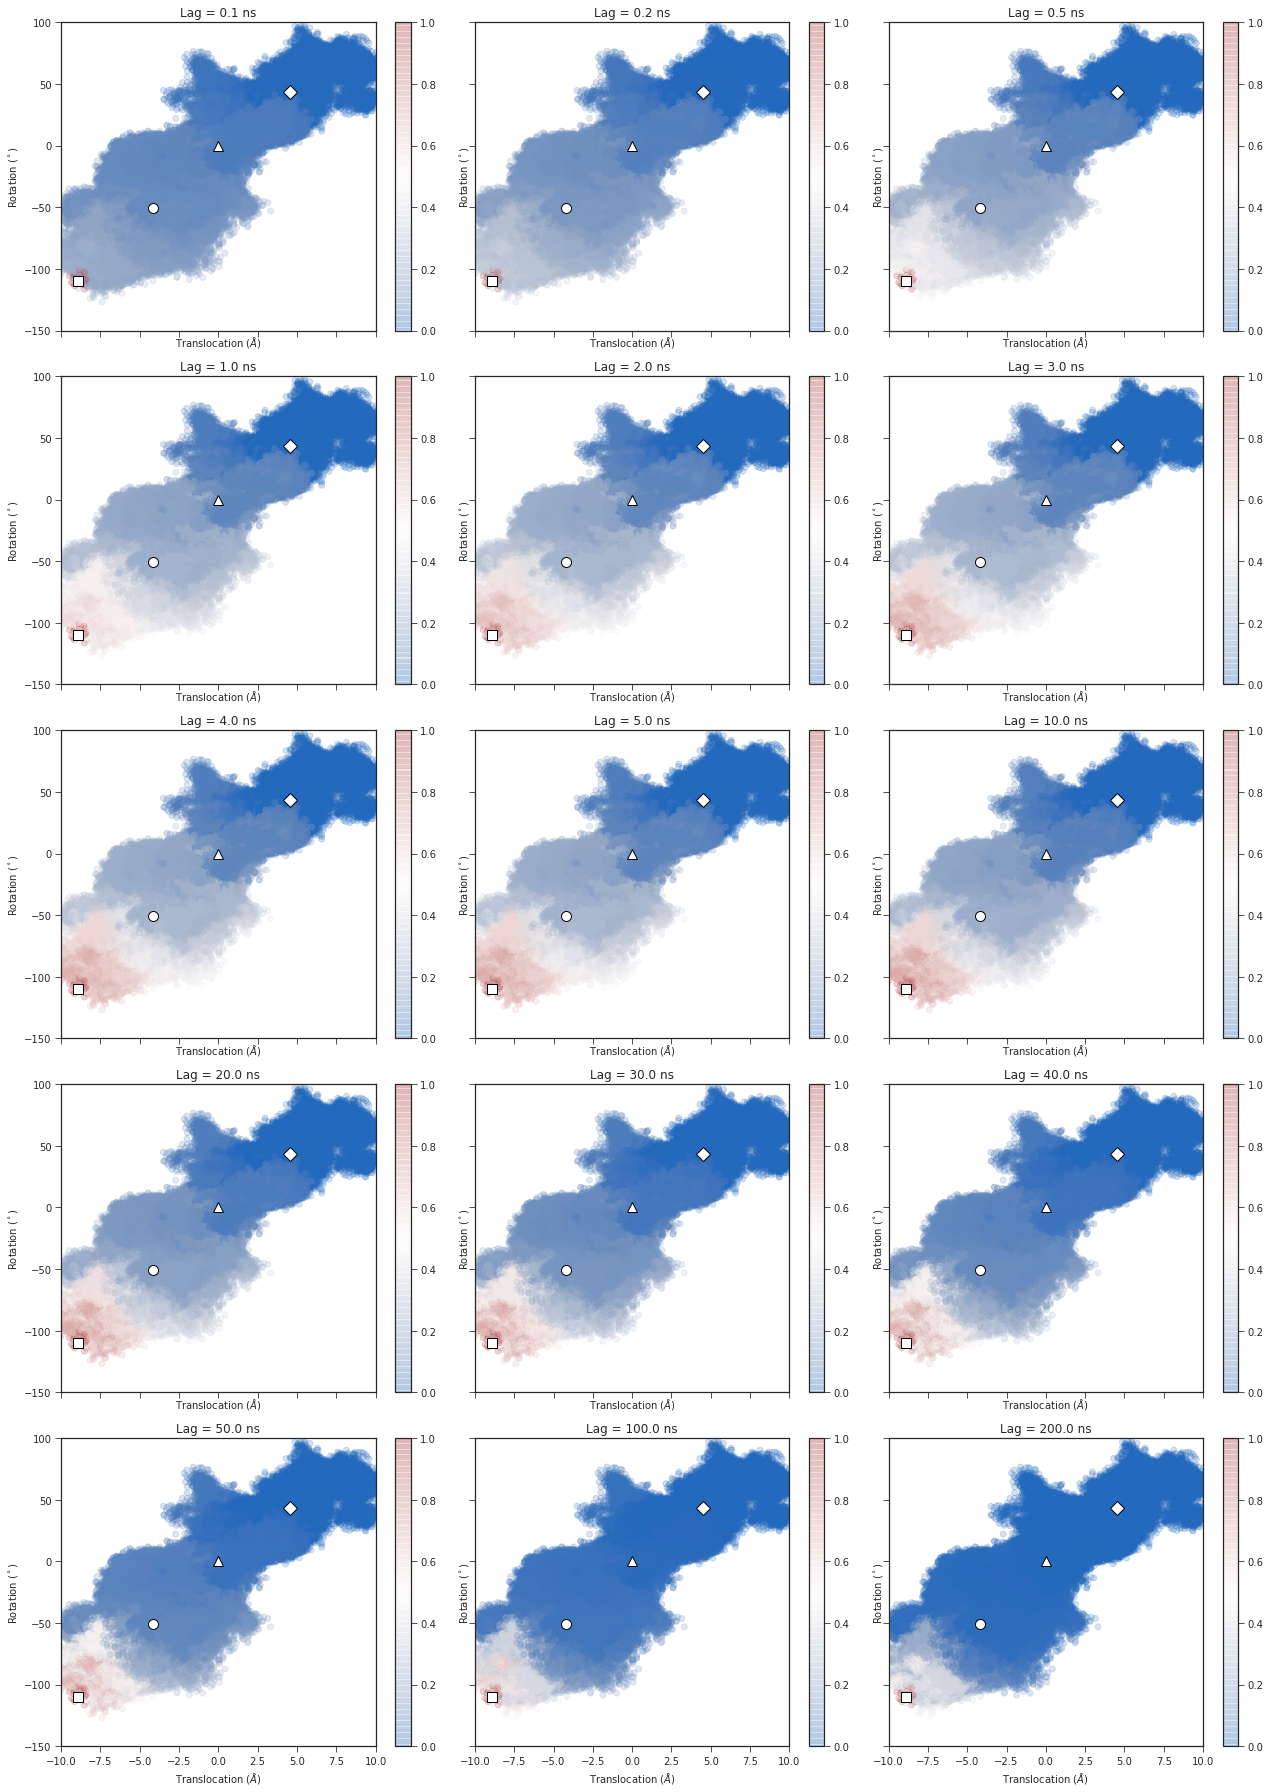

In [78]:
f, axs = plt.subplots(5, 3, figsize=(18, 25), sharex=True, sharey=True)
for lag, q, ax in zip(lags, qb_downup, axs.flatten()):
    q_arr = np.concatenate(q)
    h = ax.scatter(
        cv_arr[::10, 0], cv_arr[::10, 1], c=q_arr[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    util.format_cvs(ax)

f.tight_layout()
plt.savefig("../../fig/committors/qb_ind200_activation_alllags_ds", dpi=400)

## Deactivation (up to down) committor 

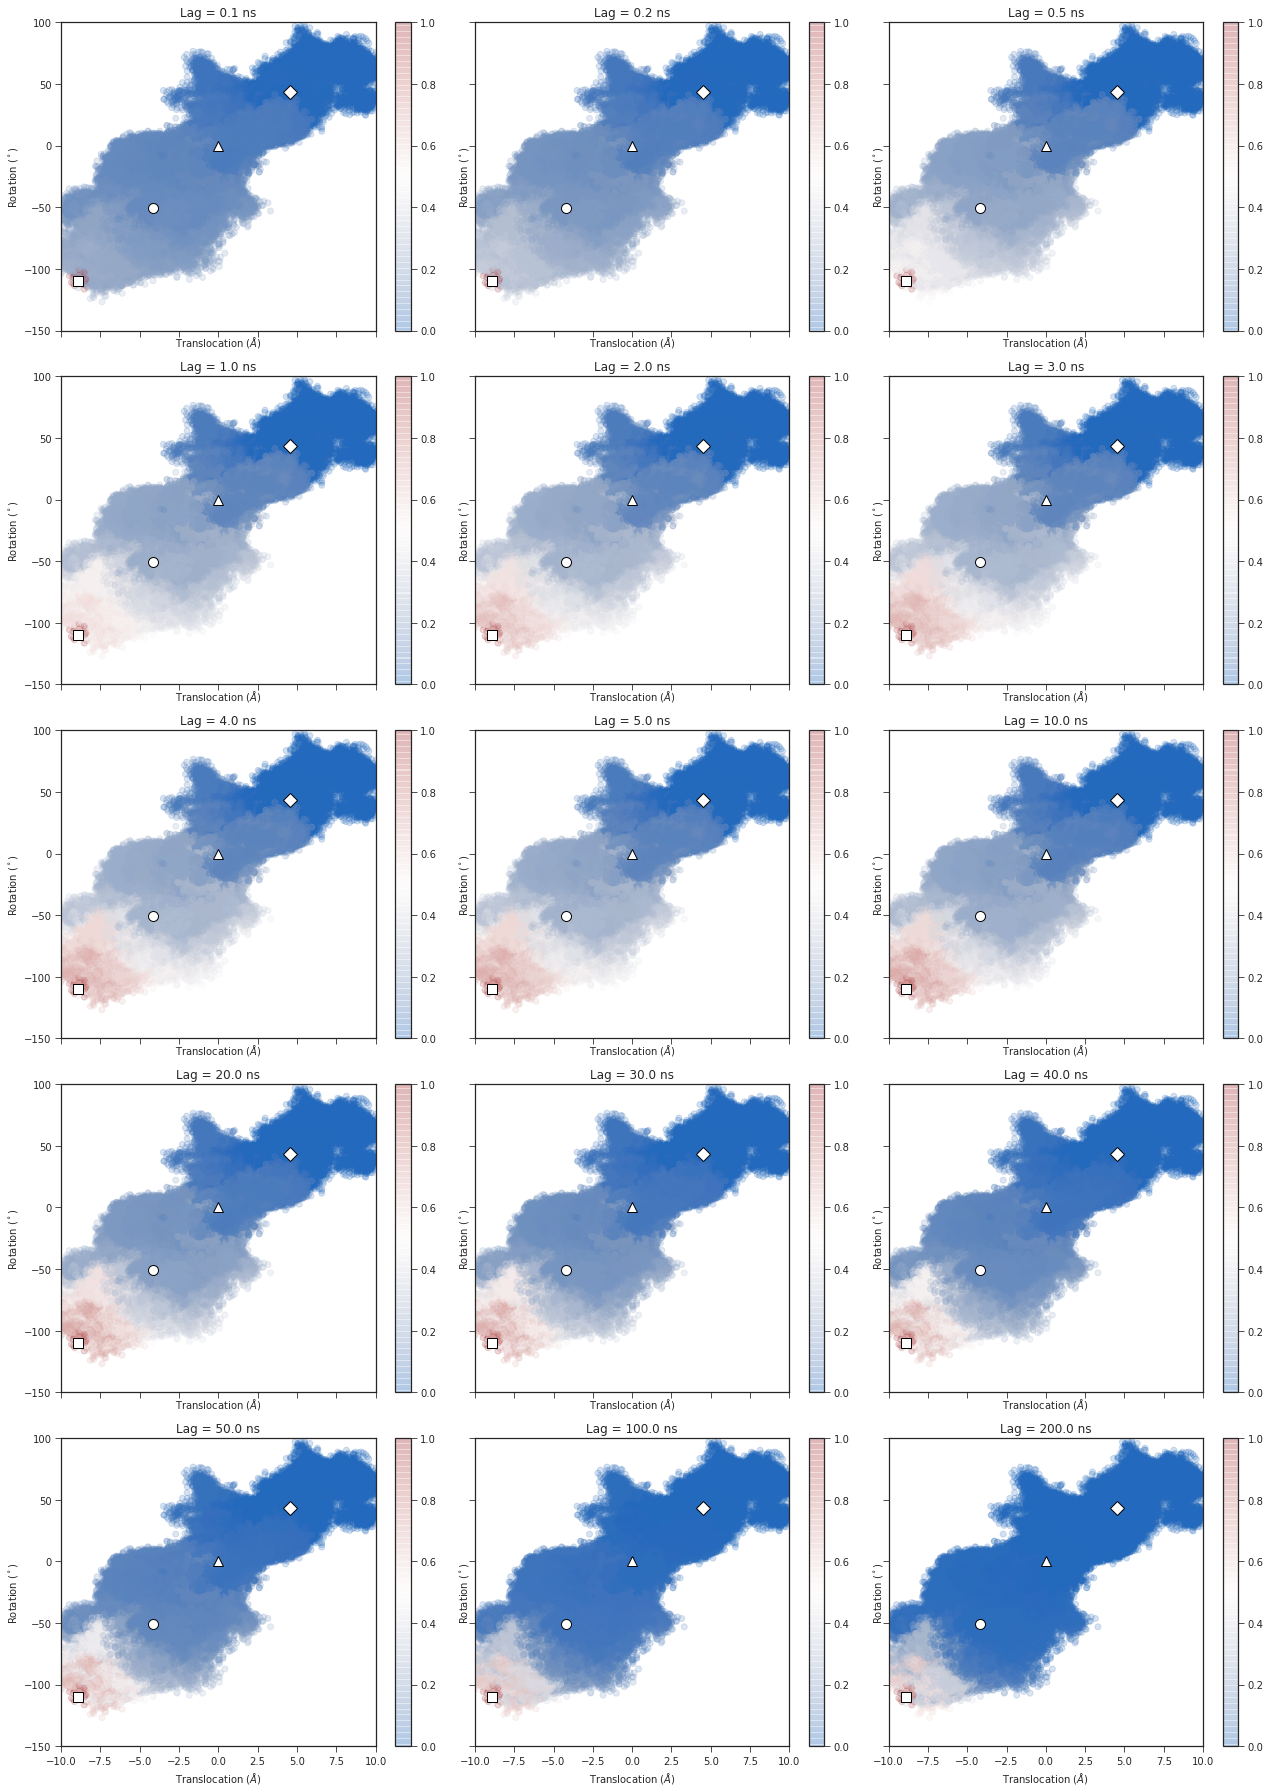

In [79]:
f, axs = plt.subplots(5, 3, figsize=(18, 25), sharex=True, sharey=True)
for lag, q, ax in zip(lags, q_updown, axs.flatten()):
    q_arr = np.concatenate(q)
    h = ax.scatter(
        cv_arr[::10, 0], cv_arr[::10, 1], c=q_arr[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    util.format_cvs(ax)

f.tight_layout()
plt.savefig("../../fig/committors/qf_ind200_deactivation_alllags_ds", dpi=400)

### backwards committor

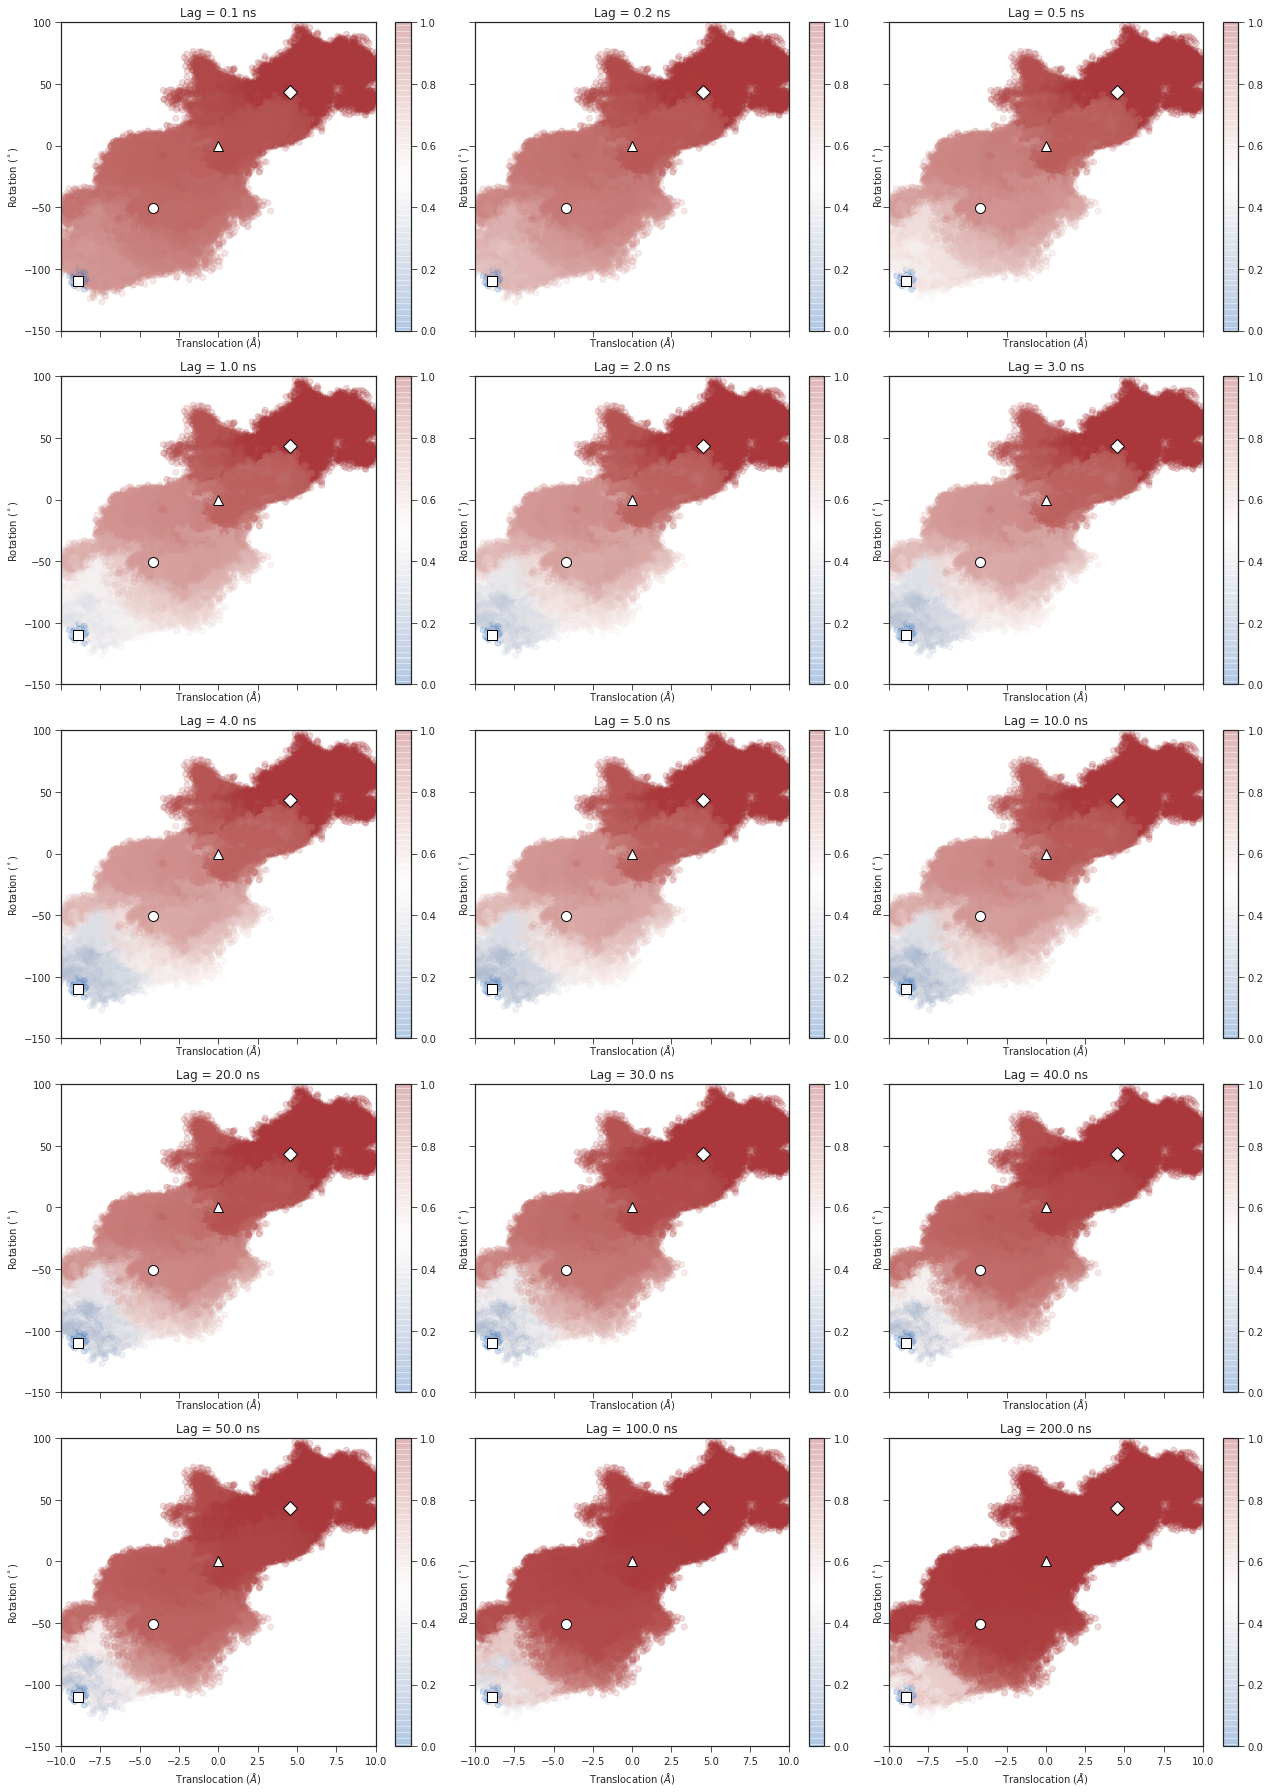

In [80]:
f, axs = plt.subplots(5, 3, figsize=(18, 25), sharex=True, sharey=True)
for lag, q, ax in zip(lags, qb_updown, axs.flatten()):
    q_arr = np.concatenate(q)
    h = ax.scatter(
        cv_arr[::10, 0], cv_arr[::10, 1], c=q_arr[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    util.format_cvs(ax)

f.tight_layout()
plt.savefig("../../fig/committors/qb_ind_200_deactivation_alllags_ds", dpi=400)